# Comparison between the algorithms suitable for Conservative Bandits

There are three possible algorithms.

1. Conservative UCB proposed in the paper, with $\psi^{\delta}(s) = 2\log \frac{Ks^3}{\delta}$
2. Conservative UCB proposed in the paper, with $\psi^{\delta}(s) = \log \max\{3, \log \zeta\} + \log (2e^2\zeta) + \frac{\zeta(1+\log \zeta)}{(\zeta-1)\log \zeta}\log \log (1+s)$, where $\zeta = \frac{K}{\delta}$
3. Modified Conservative UCB by me. When we calculate the lower bound of the cumulative reward, we use another concentration inequality.

Denote the mean reward of arm $a$ as $\mu_a$ and all the random rewards $\{X_{a,s}\}$ are 1-subgaussian. Define
$$
\begin{align*}
    \mathcal{E}_1 = & \left\{\forall a\in [K], \forall t\in\mathbb{N}: \mid \frac{\sum_{s=1}^t X_{a,s}}{t} - \mu_a \mid < (1+\sqrt{\varepsilon})\sqrt{2(1+\varepsilon)t \log\frac{K\log(1+\varepsilon)t}{\delta}}\right\}.
\end{align*}
$$
We have
$$
\begin{align*}
    \Pr\left(\mathcal{E}_1 \right)\geq 1-\frac{2+\varepsilon}{\varepsilon}\left(\frac{\delta}{\log (1+\varepsilon)}\right)^{1+\varepsilon} > 1-\frac{2+\varepsilon}{\varepsilon}\left(\frac{1}{\log (1+\varepsilon)}\right)^{1+\varepsilon}\delta
\end{align*}
$$
% If we take $\varepsilon=1$, we have $1-3(\frac{1}{\log w})^2\delta > 1-7\delta$.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import packages
from Source.env import Env_Gaussian_Fixedmu0
from Source.agent import Conservative_UCB, Conservative_UCB_rad2, Conservative_UCB_Overall_Lower_Bound

import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd

## When arm 0 is the worst arm

In this subsection we assume $\mu_0 = 0.6$, $(1-\alpha)\mu_0 = 0.5$, $\mu_1=0.9$, $\mu_2=\mu_3=\cdots=\mu_K=0.8$

In [7]:
# generate container for the records
record = pd.DataFrame(columns=["K", "n", "mu0", "r_list", "algorithm", "alpha", "delta", "Total_Reward", "Regret", "ratio", "violation"])

# generate parameter setting
K_ = np.array([50, 100, 200]) # number of arms
n_over_K = 100
alg_class = [Conservative_UCB, Conservative_UCB_rad2, Conservative_UCB_Overall_Lower_Bound]
mu0 = 0.6
alpha = 1 / 6 # the safety threshold is 0.5
delta = 0.05

n_exp = 5
for K in K_:
    n = K * n_over_K
    for alg in tqdm(alg_class):
        total_regert__ = np.zeros((n_exp, n))
        total_reward__ = np.zeros((n_exp, n))
        ratio__ = np.zeros((n_exp, n))
        violation_ = np.zeros(n_exp) # 1 denotes violation, 0 denotes non-violation

        for exp_id in range(n_exp):
            regret_ = np.zeros(n)
            reward_ = np.zeros(n)

            r_list = np.ones(K) * 0.8
            r_list[0] = 0.9
            best_reward = np.maximum(np.max(r_list), mu0)

            # shuffle the arms
            np.random.seed(exp_id)
            permuted_index = np.arange(K)
            np.random.shuffle(permuted_index)
            r_list = r_list[permuted_index]

            env = Env_Gaussian_Fixedmu0(K=K, mu0=mu0, r_list=r_list, random_seed=exp_id, n=n)
            agent = alg(K=K, mu0=mu0, alpha=alpha, delta=delta)
            while not env.if_stop():
                arm = agent.action()
                reward = env.response(arm=arm)
                agent.observe(reward=reward)

                if arm == 0:
                    reward_[env.t - 1] = mu0
                    regret_[env.t - 1] = best_reward - mu0
                else:
                    reward_[env.t - 1] = r_list[arm - 1]
                    regret_[env.t - 1] = best_reward - r_list[arm - 1]
            
            total_regert_ = np.cumsum(regret_)
            total_reward_ = np.cumsum(reward_)
            ratio_ = total_regert_ / np.arange(1, n + 1, 1)

            total_regert__[exp_id, :] = total_regert_
            total_reward__[exp_id, :] = total_reward_
            ratio__[exp_id, :] = ratio_
            violation_[exp_id] = env.if_violation()

        # safe the numeric record
        record.loc[record.shape[0]] = np.array(
            [
                K,
                n,
                mu0,
                np.array2string(r_list, threshold=11e3),
                alg.__name__,
                alpha,
                delta,
                total_reward__, total_regert__, ratio__, violation_,
            ],
            dtype=object,
        )

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.09s/it]


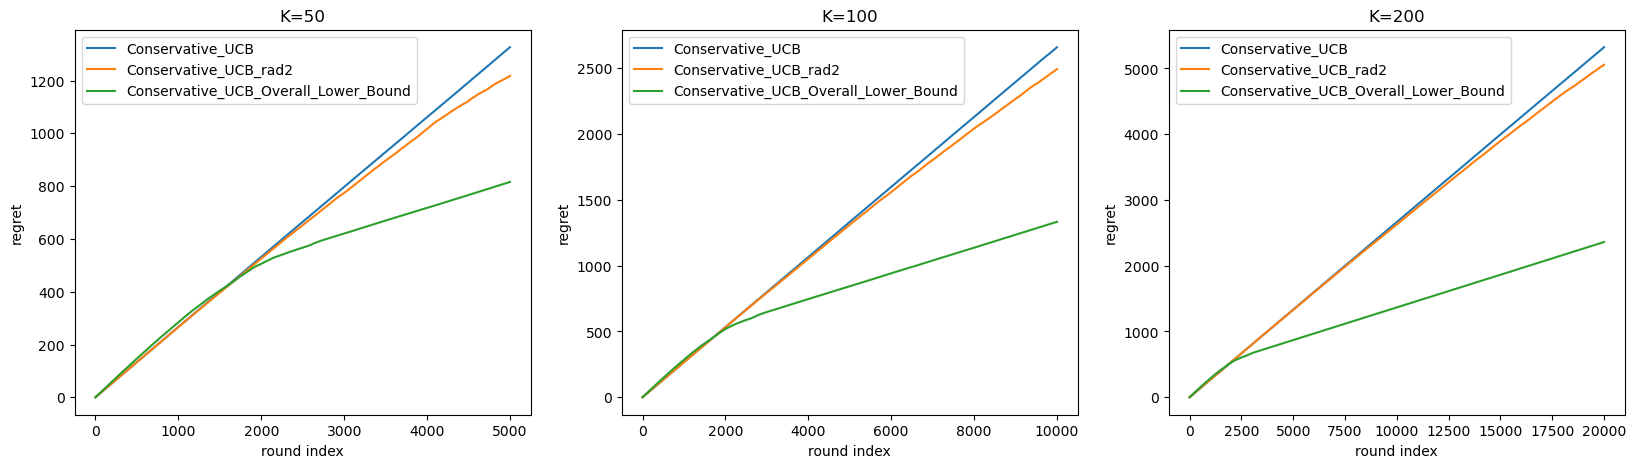

In [8]:
# plot the image
K_nums = len(record["K"].unique())
alg_name_ = len(record["algorithm"].unique())

fig, ax_ = plt.subplots(ncols = K_nums, figsize=(20, 5))
for rowid, K in enumerate(record["K"].unique()):
    for alg_name in record["algorithm"].unique():
        sub_record = record[(record["K"]==K) & (record["algorithm"]==alg_name)]
        Regret_ = sub_record["Regret"].iloc[0]
        
        Regret_mean_ = np.mean(Regret_, axis=0)
        Regret_std_ = np.std(Regret_, axis=0)
        
        ax_[rowid].plot(
            np.arange(sub_record["n"].iloc[0]), 
            Regret_mean_, label=alg_name
        )
        ax_[rowid].set_title(f"K={K}")
        ax_[rowid].set_xlabel("round index")
        ax_[rowid].set_ylabel("regret")
    ax_[rowid].legend()

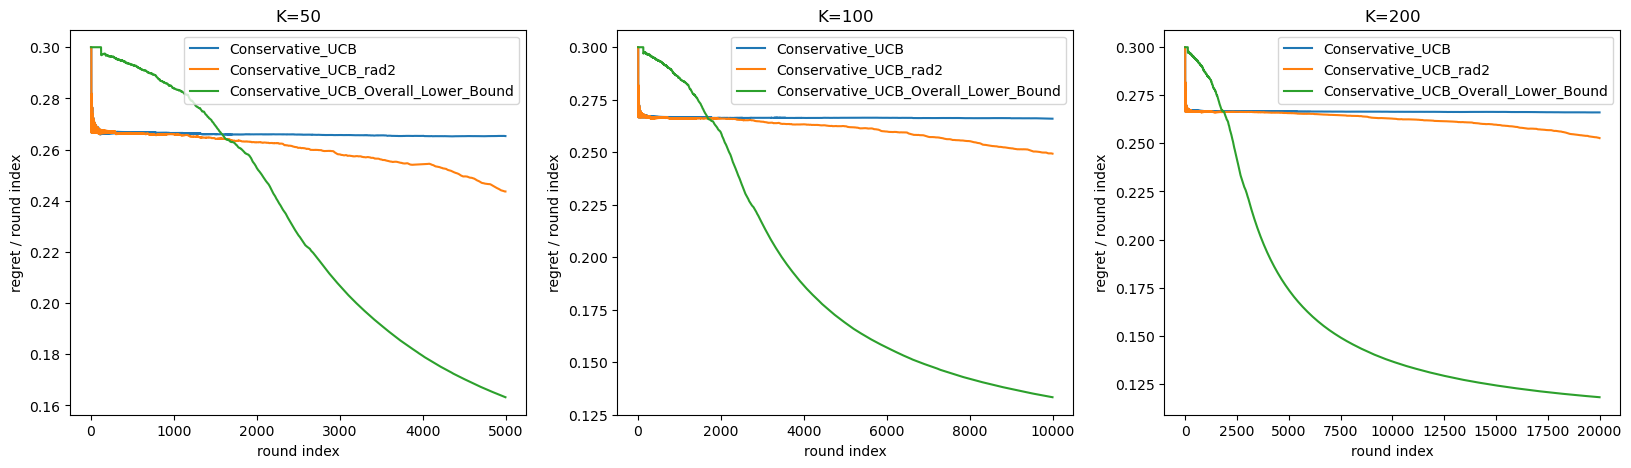

In [9]:
# plot the image
K_nums = len(record["K"].unique())
alg_name_ = len(record["algorithm"].unique())

fig, ax_ = plt.subplots(ncols = K_nums, figsize=(20, 5))
for rowid, K in enumerate(record["K"].unique()):
    for alg_name in record["algorithm"].unique():
        sub_record = record[(record["K"]==K) & (record["algorithm"]==alg_name)]
        ratio_ = sub_record["ratio"].iloc[0]
        
        ratio_mean_ = np.mean(ratio_, axis=0)
        ratio_std_ = np.std(ratio_, axis=0)
        
        ax_[rowid].plot(
            np.arange(sub_record["n"].iloc[0]), 
            ratio_mean_, label=alg_name
        )
        ax_[rowid].set_title(f"K={K}")
        ax_[rowid].set_xlabel("round index")
        ax_[rowid].set_ylabel("regret / round index")
    ax_[rowid].legend()

In [11]:
# output the violation times
K_nums = len(record["K"].unique())
alg_name_ = len(record["algorithm"].unique())

for rowid, K in enumerate(record["K"].unique()):
    for alg_name in record["algorithm"].unique():
        sub_record = record[(record["K"]==K) & (record["algorithm"]==alg_name)]
        violation = sub_record["violation"].iloc[0]
        print(f"K={K}, alg={alg_name}, violation number is {np.sum(violation)}")

K=50, alg=Conservative_UCB, violation number is 0.0
K=50, alg=Conservative_UCB_rad2, violation number is 0.0
K=50, alg=Conservative_UCB_Overall_Lower_Bound, violation number is 0.0
K=100, alg=Conservative_UCB, violation number is 0.0
K=100, alg=Conservative_UCB_rad2, violation number is 0.0
K=100, alg=Conservative_UCB_Overall_Lower_Bound, violation number is 0.0
K=200, alg=Conservative_UCB, violation number is 0.0
K=200, alg=Conservative_UCB_rad2, violation number is 0.0
K=200, alg=Conservative_UCB_Overall_Lower_Bound, violation number is 0.0


## When arm 0 is the middle arm

In this subsection we assume $\mu_0 = 0.6$, $\mu_1=\mu_2=\mu_3=\cdots=\mu_{\frac{K}{2}}=0.8$, $\mu_{\frac{K}{2}+1}=\mu_2=\mu_3=\cdots=\mu_{K}=0.4$

In [14]:
# generate container for the records
record = pd.DataFrame(columns=["K", "n", "mu0", "r_list", "algorithm", "alpha", "delta", "Total_Reward", "Regret", "ratio", "violation"])

# generate parameter setting
K_ = np.array([50, 100, 200]) # number of arms
n_over_K = 100
alg_class = [Conservative_UCB, Conservative_UCB_rad2, Conservative_UCB_Overall_Lower_Bound]
mu0 = 0.6
alpha = 1 / 6 # the safety threshold is 0.5
delta = 0.05

n_exp = 5
for K in K_:
    n = K * n_over_K
    for alg in tqdm(alg_class):
        total_regert__ = np.zeros((n_exp, n))
        total_reward__ = np.zeros((n_exp, n))
        ratio__ = np.zeros((n_exp, n))
        violation_ = np.zeros(n_exp) # 1 denotes violation, 0 denotes non-violation

        for exp_id in range(n_exp):
            regret_ = np.zeros(n)
            reward_ = np.zeros(n)

            r_list = np.ones(K) * 0.8
            r_list[K//2:] = 0.4
            best_reward = np.maximum(np.max(r_list), mu0)

            # shuffle the arms
            np.random.seed(exp_id)
            permuted_index = np.arange(K)
            np.random.shuffle(permuted_index)
            r_list = r_list[permuted_index]

            env = Env_Gaussian_Fixedmu0(K=K, mu0=mu0, r_list=r_list, random_seed=exp_id, n=n)
            agent = alg(K=K, mu0=mu0, alpha=alpha, delta=delta)
            while not env.if_stop():
                arm = agent.action()
                reward = env.response(arm=arm)
                agent.observe(reward=reward)

                if arm == 0:
                    reward_[env.t - 1] = mu0
                    regret_[env.t - 1] = best_reward - mu0
                else:
                    reward_[env.t - 1] = r_list[arm - 1]
                    regret_[env.t - 1] = best_reward - r_list[arm - 1]
            
            total_regert_ = np.cumsum(regret_)
            total_reward_ = np.cumsum(reward_)
            ratio_ = total_regert_ / np.arange(1, n + 1, 1)

            total_regert__[exp_id, :] = total_regert_
            total_reward__[exp_id, :] = total_reward_
            ratio__[exp_id, :] = ratio_
            violation_[exp_id] = env.if_violation()

        # safe the numeric record
        record.loc[record.shape[0]] = np.array(
            [
                K,
                n,
                mu0,
                np.array2string(r_list, threshold=11e3),
                alg.__name__,
                alpha,
                delta,
                total_reward__, total_regert__, ratio__, violation_,
            ],
            dtype=object,
        )

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:14<00:00,  4.84s/it]


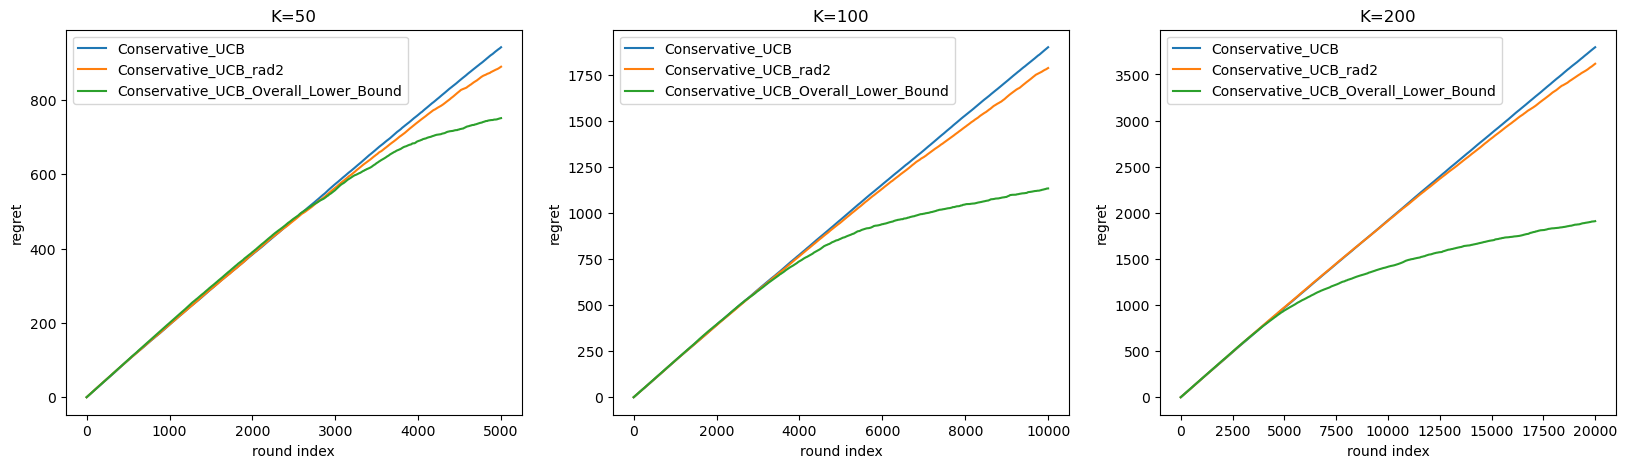

In [15]:
# plot the image
K_nums = len(record["K"].unique())
alg_name_ = len(record["algorithm"].unique())

fig, ax_ = plt.subplots(ncols = K_nums, figsize=(20, 5))
for rowid, K in enumerate(record["K"].unique()):
    for alg_name in record["algorithm"].unique():
        sub_record = record[(record["K"]==K) & (record["algorithm"]==alg_name)]
        Regret_ = sub_record["Regret"].iloc[0]
        
        Regret_mean_ = np.mean(Regret_, axis=0)
        Regret_std_ = np.std(Regret_, axis=0)
        
        ax_[rowid].plot(
            np.arange(sub_record["n"].iloc[0]), 
            Regret_mean_, label=alg_name
        )
        ax_[rowid].set_title(f"K={K}")
        ax_[rowid].set_xlabel("round index")
        ax_[rowid].set_ylabel("regret")
    ax_[rowid].legend()

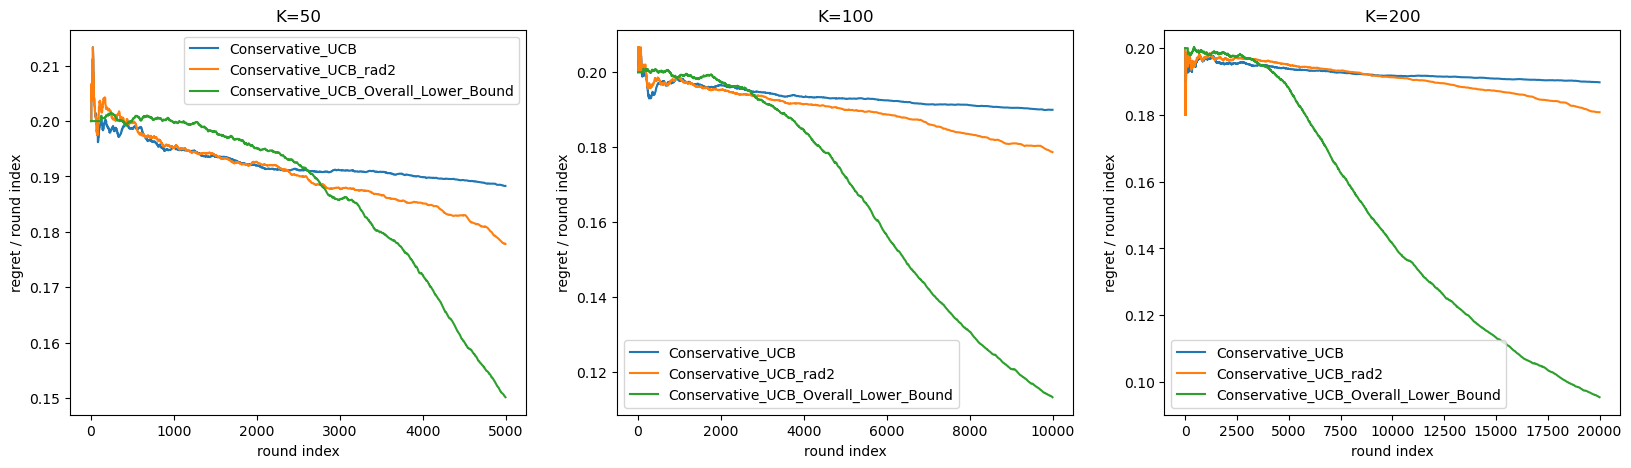

In [16]:
# plot the image
K_nums = len(record["K"].unique())
alg_name_ = len(record["algorithm"].unique())

fig, ax_ = plt.subplots(ncols = K_nums, figsize=(20, 5))
for rowid, K in enumerate(record["K"].unique()):
    for alg_name in record["algorithm"].unique():
        sub_record = record[(record["K"]==K) & (record["algorithm"]==alg_name)]
        ratio_ = sub_record["ratio"].iloc[0]
        
        ratio_mean_ = np.mean(ratio_, axis=0)
        ratio_std_ = np.std(ratio_, axis=0)
        
        ax_[rowid].plot(
            np.arange(sub_record["n"].iloc[0]), 
            ratio_mean_, label=alg_name
        )
        ax_[rowid].set_title(f"K={K}")
        ax_[rowid].set_xlabel("round index")
        ax_[rowid].set_ylabel("regret / round index")
    ax_[rowid].legend()

In [17]:
# output the violation times
K_nums = len(record["K"].unique())
alg_name_ = len(record["algorithm"].unique())

for rowid, K in enumerate(record["K"].unique()):
    for alg_name in record["algorithm"].unique():
        sub_record = record[(record["K"]==K) & (record["algorithm"]==alg_name)]
        violation = sub_record["violation"].iloc[0]
        print(f"K={K}, alg={alg_name}, violation number is {np.sum(violation)}")

K=50, alg=Conservative_UCB, violation number is 0.0
K=50, alg=Conservative_UCB_rad2, violation number is 0.0
K=50, alg=Conservative_UCB_Overall_Lower_Bound, violation number is 0.0
K=100, alg=Conservative_UCB, violation number is 0.0
K=100, alg=Conservative_UCB_rad2, violation number is 0.0
K=100, alg=Conservative_UCB_Overall_Lower_Bound, violation number is 0.0
K=200, alg=Conservative_UCB, violation number is 0.0
K=200, alg=Conservative_UCB_rad2, violation number is 0.0
K=200, alg=Conservative_UCB_Overall_Lower_Bound, violation number is 0.0
